In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Preprocessing

In [2]:
import os
from random import shuffle
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
import ast
import torch
from torch.utils.data import Dataset
import os
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

Загрузка словаря. Будем использовать 10000 самых популярных слов.

In [3]:
vocab = {}
f = open('/content/drive/MyDrive/nlp/aclImdb/imdb.vocab')
ZERO = 0
UNDEF = 1
for i in range(10000):
  d = f.readline()[:-1]
  vocab[d] = i + 2

In [5]:
LEN = 200

Из каждого описания удалим знаки препинания и цифры (предварительно добавив пробелы, чтобы обработать случаи, когда пропущены пробелы в исходном тексте). Затем каждое слово заменим на его код из словаря, либо на код UNDEF=1, если такое слово в словаре отсутствует. Вектор, соответствующий каждому тексту сделаем длиной LEN=200, если длина текста больше LEN, то последние слова не добавляются в вектор, если длина текста меньше LEN, то в вектор добавляются заполнители ZERO=0, так чтобы его длина была равна LEN.

In [6]:
def preprocess_data(path):
  filenames = sorted(os.listdir(path))
  for i in range(len(filenames)):
    filenames[i] = path + filenames[i]
  new_data = []
  for filename in tqdm(filenames):
    f = open(filename)
    data = f.read()
    data = re.sub(r'([\.\,\!\?\-])', r' \1 ', data) # добавляем пробелы
    data = re.sub(r'([^\x00-\x7f])', r'', data) # удяляем не алфавитные символы
    data = re.sub(r'([\,\.\!\?\-\"\#\$\%\&\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~1234567890])', '', data) # удаляем знаки препинания и цифры
    data = data.split(' ') # разбиваем текст на слова
    vec = []
    counter = 0
    for word in data: # для каждого слова
      if counter == LEN: # лимит на кол-во элементов в векторе
       break
      if len(word) < 2:
        continue
      if (word[0] == "'"): # дополнительно убираем одинарные кавычки по краям (ранее они не удалились, чтобы оставить их в артиклях)
        word = word[1:]
      if len(word) < 2:
        continue
      if (word[-1] == "'"):
        word = word[:-1]
      if len(word) < 2:
        continue
      word = word.lower() # нижний регистр
      if word in vocab:
        vec.append(vocab[word]) # добавляем в вектор код слова
      else:
        vec.append(UNDEF) # добавляем в вектор код UNDEF
      counter += 1
    dop = LEN - len(vec)
    for i in range(dop): # заполняем вектор нулями до длины 200 (если длина меньше)
      vec.append(ZERO)
    label = 0
    if 'pos' in filename: # определяем ответ
      label = 1
    new_data.append([vec, label])
  return new_data

In [7]:
path_pos_train = '/content/drive/MyDrive/nlp/aclImdb/train/pos/'
path_neg_train = '/content/drive/MyDrive/nlp/aclImdb/train/neg/'
path_pos_test = '/content/drive/MyDrive/nlp/aclImdb/test/pos/'
path_neg_test = '/content/drive/MyDrive/nlp/aclImdb/test/neg/'

Обработаем все данные и сохраним

In [8]:
new_data = preprocess_data(path_pos_train)
df = pd.DataFrame(new_data, columns=['feature', 'label'])
print(len(df))
df.to_csv('/content/drive/MyDrive/nlp/preprocessed/pos_train.csv', index=False)

100%|██████████| 12500/12500 [06:49<00:00, 30.54it/s] 


12500


In [9]:
new_data = preprocess_data(path_neg_train)
df = pd.DataFrame(new_data, columns=['feature', 'label'])
print(len(df))
df.to_csv('/content/drive/MyDrive/nlp/preprocessed/neg_train.csv', index=False)

100%|██████████| 12500/12500 [06:34<00:00, 31.68it/s] 


12500


In [10]:
new_data = preprocess_data(path_pos_test)
df = pd.DataFrame(new_data, columns=['feature', 'label'])
print(len(df))
df.to_csv('/content/drive/MyDrive/nlp/preprocessed/pos_test.csv', index=False)

100%|██████████| 12500/12500 [06:16<00:00, 33.23it/s] 


12500


In [11]:
new_data = preprocess_data(path_neg_test)
df = pd.DataFrame(new_data, columns=['feature', 'label'])
print(len(df))
df.to_csv('/content/drive/MyDrive/nlp/preprocessed/neg_test.csv', index=False)

100%|██████████| 12500/12500 [07:28<00:00, 27.88it/s] 


12500


In [3]:
pos_train = pd.read_csv('/content/drive/MyDrive/nlp/preprocessed/pos_train.csv')
neg_train = pd.read_csv('/content/drive/MyDrive/nlp/preprocessed/neg_train.csv')

In [4]:
class CustomDataset(Dataset): # код датасета для сбалансированной подгрузки данных из датафреймов
    def __init__(self, mode):
        x = 0
        y = 0
        if mode == 'train': # загрузка 80% данных
          x = 0
          y = 10000
        if mode == 'val': # загрузка 20% данных
          x = 10000
          y = 12500
        if mode == 'test': # загрузка всех данных
          x = 0
          y = 12500
        pos_data = np.array(pos_train)[x:y]
        neg_data = np.array(neg_train)[x:y]
        self.data = np.concatenate([pos_data, neg_data], axis=0)
        idx = np.arange(len(self.data))
        np.random.shuffle(idx) # случайный порядок строк матрицы данных
        self.data = self.data[idx]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        label = row[1]
        feature = ast.literal_eval(row[0]) # создание списка из строки датафрейма
        return torch.tensor(feature), label

In [20]:
class SimpleModel(nn.Module): # код модели для обучения
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.embedding = nn.Embedding(10002, 200)
        self.norm1 = nn.BatchNorm1d(200)
        self.lstm = nn.LSTM(200, 512, 2, dropout=0.2, batch_first=True)
        self.norm2 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(512, 256)
        self.norm3 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.norm4 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.long()
        x = self.norm1(self.embedding(x))
        x =  self.lstm(x)[0][:, -1, :]
        x = self.dropout1(self.norm2(x))
        x = F.relu(self.norm3(self.fc1(x)))
        x = F.relu(self.norm4(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [33]:
device = torch.device('cuda')

In [34]:
def weights_init(m, mean=0.0, std=0.02):  # инициализация весов
  if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    nn.init.normal_(m.weight.data, mean, std)

model = SimpleModel().to(device)
model.apply(weights_init)

SimpleModel(
  (embedding): Embedding(10002, 200)
  (norm1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(200, 512, num_layers=2, batch_first=True, dropout=0.2)
  (norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (norm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (norm4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Обучим модель и сохраним модель с наилучшим accuracy на валидации.

In [35]:
lr = 0.001
BCE_loss = nn.BCELoss()
optim = Adam(model.parameters(), lr=lr)
epochs = 10
batch_size = 128

train_dataset = CustomDataset('train')
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataset('val')
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [36]:
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

best_loss = 1000
best_epoch = 0

for epoch in range(epochs):
    print('Epoch: ', epoch)
    model.train()

    train_loss = 0
    train_acc = 0

    for input, label in tqdm(train_dataloader):
        input, label = input.to(device), label.to(device)
        optim.zero_grad()
        out = model(input)
        pred = torch.tensor([1 if i == True else 0 for i in out > 0.5]).to(device)
        tp = ((label.float() == 1)&(pred == 1)).sum()
        tn = ((label.float() == 0)&(pred == 0)).sum()
        fp = ((label.float() == 1)&(pred == 0)).sum()
        fn = ((label.float() == 0)&(pred == 1)).sum()
        acc = (tp + tn) / (tp + tn + fn + fp)
        train_acc += acc.item()
        loss = BCE_loss(out.squeeze(), label.float())
        train_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optim.step()
    print('Train loss: ', train_loss / len(train_dataloader))
    train_loss_history.append(train_loss / len(train_dataloader))
    print('Train accuracy: ', train_acc / len(train_dataloader))
    train_acc_history.append(train_acc / len(train_dataloader))

    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for input, label in tqdm(val_dataloader):
            input, label = input.to(device), label.to(device)
            out = model(input)
            pred = torch.tensor([1 if i == True else 0 for i in out > 0.5]).to(device)
            tp = ((label.float() == 1)&(pred == 1)).sum()
            tn = ((label.float() == 0)&(pred == 0)).sum()
            fp = ((label.float() == 1)&(pred == 0)).sum()
            fn = ((label.float() == 0)&(pred == 1)).sum()
            acc = (tp + tn) / (tp + tn + fn + fp)
            val_acc += acc.item()
            loss = BCE_loss(out.squeeze(), label.float())
            val_loss += loss.item()
        print('Validation loss: ', val_loss / len(val_dataloader))
        val_loss_history.append(val_loss / len(val_dataloader))
        if ((val_loss / len(val_dataloader)) < best_loss):
          torch.save(model.state_dict(), '/content/drive/MyDrive/nlp/trained_model.pth')
          best_epoch = epoch
          best_loss = (val_loss / len(val_dataloader))
        print('Validation accuracy: ', val_acc / len(val_dataloader))
        val_acc_history.append(val_acc / len(val_dataloader))

Epoch:  0


100%|██████████| 157/157 [00:36<00:00,  4.28it/s]


Train loss:  0.6995643449437087
Train accuracy:  0.5033339968152867


100%|██████████| 40/40 [00:03<00:00, 10.74it/s]


Validation loss:  0.6945660188794136
Validation accuracy:  0.5037109375
Epoch:  1


100%|██████████| 157/157 [00:36<00:00,  4.29it/s]


Train loss:  0.6939336744843015
Train accuracy:  0.5108479299363057


100%|██████████| 40/40 [00:04<00:00,  9.69it/s]


Validation loss:  0.7043877050280571
Validation accuracy:  0.5
Epoch:  2


100%|██████████| 157/157 [00:36<00:00,  4.30it/s]


Train loss:  0.6877519587042985
Train accuracy:  0.533140923566879


100%|██████████| 40/40 [00:03<00:00, 10.82it/s]


Validation loss:  0.6935401812195778
Validation accuracy:  0.5
Epoch:  3


100%|██████████| 157/157 [00:36<00:00,  4.31it/s]


Train loss:  0.6026673865546087
Train accuracy:  0.6416699840764332


100%|██████████| 40/40 [00:03<00:00, 10.76it/s]


Validation loss:  1.2342676550149918
Validation accuracy:  0.5421875
Epoch:  4


100%|██████████| 157/157 [00:36<00:00,  4.32it/s]


Train loss:  0.34959401190280914
Train accuracy:  0.8497213375796179


100%|██████████| 40/40 [00:03<00:00, 10.77it/s]


Validation loss:  0.5377580180764199
Validation accuracy:  0.756640625
Epoch:  5


100%|██████████| 157/157 [00:36<00:00,  4.33it/s]


Train loss:  0.2466657009853679
Train accuracy:  0.9017217356687898


100%|██████████| 40/40 [00:03<00:00, 10.84it/s]


Validation loss:  0.3779733099043369
Validation accuracy:  0.828515625
Epoch:  6


100%|██████████| 157/157 [00:36<00:00,  4.33it/s]


Train loss:  0.1776741423234818
Train accuracy:  0.9339171974522293


100%|██████████| 40/40 [00:04<00:00, 10.00it/s]


Validation loss:  0.4133706144988537
Validation accuracy:  0.841015625
Epoch:  7


100%|██████████| 157/157 [00:36<00:00,  4.34it/s]


Train loss:  0.13057980285423576
Train accuracy:  0.955015923566879


100%|██████████| 40/40 [00:04<00:00,  9.52it/s]


Validation loss:  0.6006807878613472
Validation accuracy:  0.806640625
Epoch:  8


100%|██████████| 157/157 [00:36<00:00,  4.36it/s]


Train loss:  0.08788267785244307
Train accuracy:  0.9710887738853503


100%|██████████| 40/40 [00:04<00:00,  9.06it/s]


Validation loss:  0.606652881577611
Validation accuracy:  0.823828125
Epoch:  9


100%|██████████| 157/157 [00:35<00:00,  4.39it/s]


Train loss:  0.06229005305535475
Train accuracy:  0.9804438694267515


100%|██████████| 40/40 [00:04<00:00,  8.42it/s]

Validation loss:  0.6688642531633378
Validation accuracy:  0.8265625


In [37]:
print('Best epoch: ', best_epoch)

Best epoch:  5


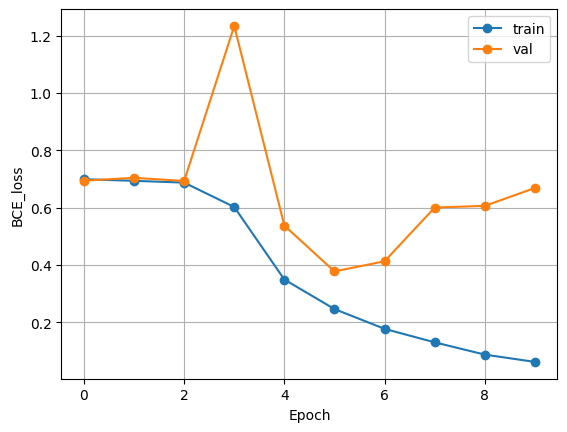

In [40]:
x = np.arange(10)
plt.plot(x, train_loss_history, '-o', label='train')
plt.plot(x, val_loss_history, '-o', label='val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('BCE_loss')
plt.show()

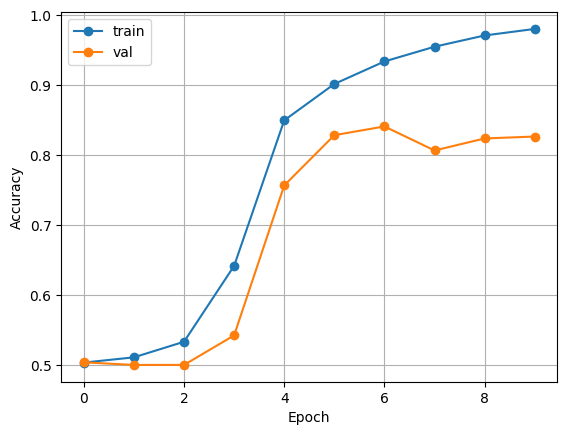

In [41]:
x = np.arange(10)
plt.plot(x, train_acc_history, '-o', label='train')
plt.plot(x, val_acc_history, '-o', label='val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Проверим работу модели на тестовых данных

In [43]:
model = SimpleModel().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/nlp/trained_model.pth'))
model.eval()

SimpleModel(
  (embedding): Embedding(10002, 200)
  (norm1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(200, 512, num_layers=2, batch_first=True, dropout=0.2)
  (norm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (norm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (norm4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [44]:
pos_test = pd.read_csv('/content/drive/MyDrive/nlp/preprocessed/pos_test.csv')
neg_test = pd.read_csv('/content/drive/MyDrive/nlp/preprocessed/neg_test.csv')

In [48]:
test_dataset = CustomDataset('test')
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [50]:
test_acc = 0
test_loss = 0
test_precision = 0
test_recall = 0
test_f1 = 0
with torch.no_grad():
  for input, label in tqdm(test_dataloader):
    input, label = input.to(device), label.to(device)
    out = model(input)
    pred = torch.tensor([1 if i == True else 0 for i in out > 0.5]).to(device)
    tp = ((label.float() == 1)&(pred == 1)).sum()
    tn = ((label.float() == 0)&(pred == 0)).sum()
    fp = ((label.float() == 1)&(pred == 0)).sum()
    fn = ((label.float() == 0)&(pred == 1)).sum()
    acc = (tp + tn) / (tp + tn + fn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    test_acc += acc.item()
    loss = BCE_loss(out.squeeze(), label.float())
    test_loss += loss.item()
    test_precision += precision.item()
    test_recall += recall.item()
    test_f1 += f1.item()
print()
print('Test accuracy: ', test_acc / len(test_dataloader))
print('Test precision: ', test_precision / len(test_dataloader))
print('Test recall: ', test_recall / len(test_dataloader))
print('Test F1: ', test_f1 / len(test_dataloader))

100%|██████████| 196/196 [00:22<00:00,  8.60it/s]


Test accuracy:  0.9192602041424537
Test precision:  0.8978852386377296
Test recall:  0.9379380430494036
Test F1:  0.9168814323386367
